## DSC-680 Project#3

### Name: <span style="font-size: smaller;">Syed Shahid Shabbir</span>

#### Stroke Risk Prediction

##### Project Overview:
This project explores the application of machine learning in stroke prediction, leveraging a dataset from Kaggle that includes demographic, medical history, and lifestyle factors. Due to the severe class imbalance, various resampling techniques, class weighting, and feature engineering were employed to improve predictive performance. Multiple classification models were tested, with Logistic Regression, Support Vector Classifier (SVC), and Stochastic Gradient Descent (SGD) emerging as top performers based on Matthews Correlation Coefficient (MCC), AUC, and Recall. Despite data limitations—including missing key risk factors and a lack of longitudinal tracking—the study demonstrates that machine learning can effectively identify stroke risks, offering valuable insights for early detection and preventive healthcare.

Links to the Dataset: https://www.kaggle.com/datasets/lirilkumaramal/heart-stroke , https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


In [9]:
## Libraries
import pandas as pd
import numpy as np
from pandas.core.common import random_state
# plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# encoding categorical variables
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
# split dataset
from sklearn.model_selection import train_test_split
# data transformations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
# balancing data
from collections import Counter
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# model comparison
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef, roc_auc_score, recall_score
# classification models
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
# tuning and model ensembles
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier


In [12]:
# Load the datasets
# dataframes creation for both training and testing datasets 
df = pd.read_csv(r'E:\DSC_Bellieve\DSC_680\Project_3\Week9\train_strokes.csv', index_col=0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [17]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 43400 entries, 30669 to 36271
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.0+ MB


,count,mean,std,min,25%,50%,75%,max
age,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
hypertension,43400.0,0.093571,0.291235,0.00,0.00,0.00,0.00,1.00
heart_disease,43400.0,0.047512,0.212733,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
bmi,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60
stroke,43400.0,0.018041,0.133103,0.00,0.00,0.00,0.00,1.00


* Minimum `age` of 0.08 years (1 month) is unlikely to be correct. Will need to look at distribution and establish a cutoff.

* `hypertension` and `heart_disease` appear to already be scaled 0-1, which is probably fine.

* `avg_glucose_level` Note: "A blood sugar level less than 140 mg/dL (7.8 mmol/L) is normal. A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes. A reading between 140 and 199 mg/dL (7.8 mmol/L and 11.0 mmol/L) indicates prediabetes." per [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451)

* A minimum `bmi` of [10.10 is not entirely unreasonable](https://www.ennonline.net/fex/15/limits).

In [23]:
# Categorical Data
df.describe(exclude=['float', 'int']).T

,count,unique,top,freq
gender,43400,3,Female,25665
ever_married,43400,2,Yes,27938
work_type,43400,5,Private,24834
Residence_type,43400,2,Urban,21756
smoking_status,30108,3,never smoked,16053


In [24]:
# Count null values in each column
df.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

### Data Pre-Processing

In [25]:
# Changing null smoking values to class 'unknown'
df['smoking_status'] = df['smoking_status'].fillna('unknown')
df.smoking_status.value_counts()

smoking_status
never smoked       16053
unknown            13292
formerly smoked     7493
smokes              6562
Name: count, dtype: int64

In [27]:
# swap out to simpler smoking descriptions
df['smoking_status'].replace(['never smoked', 'formerly smoked', 'smokes'],
                                   ['never', 'former', 'smoker'], inplace=True)

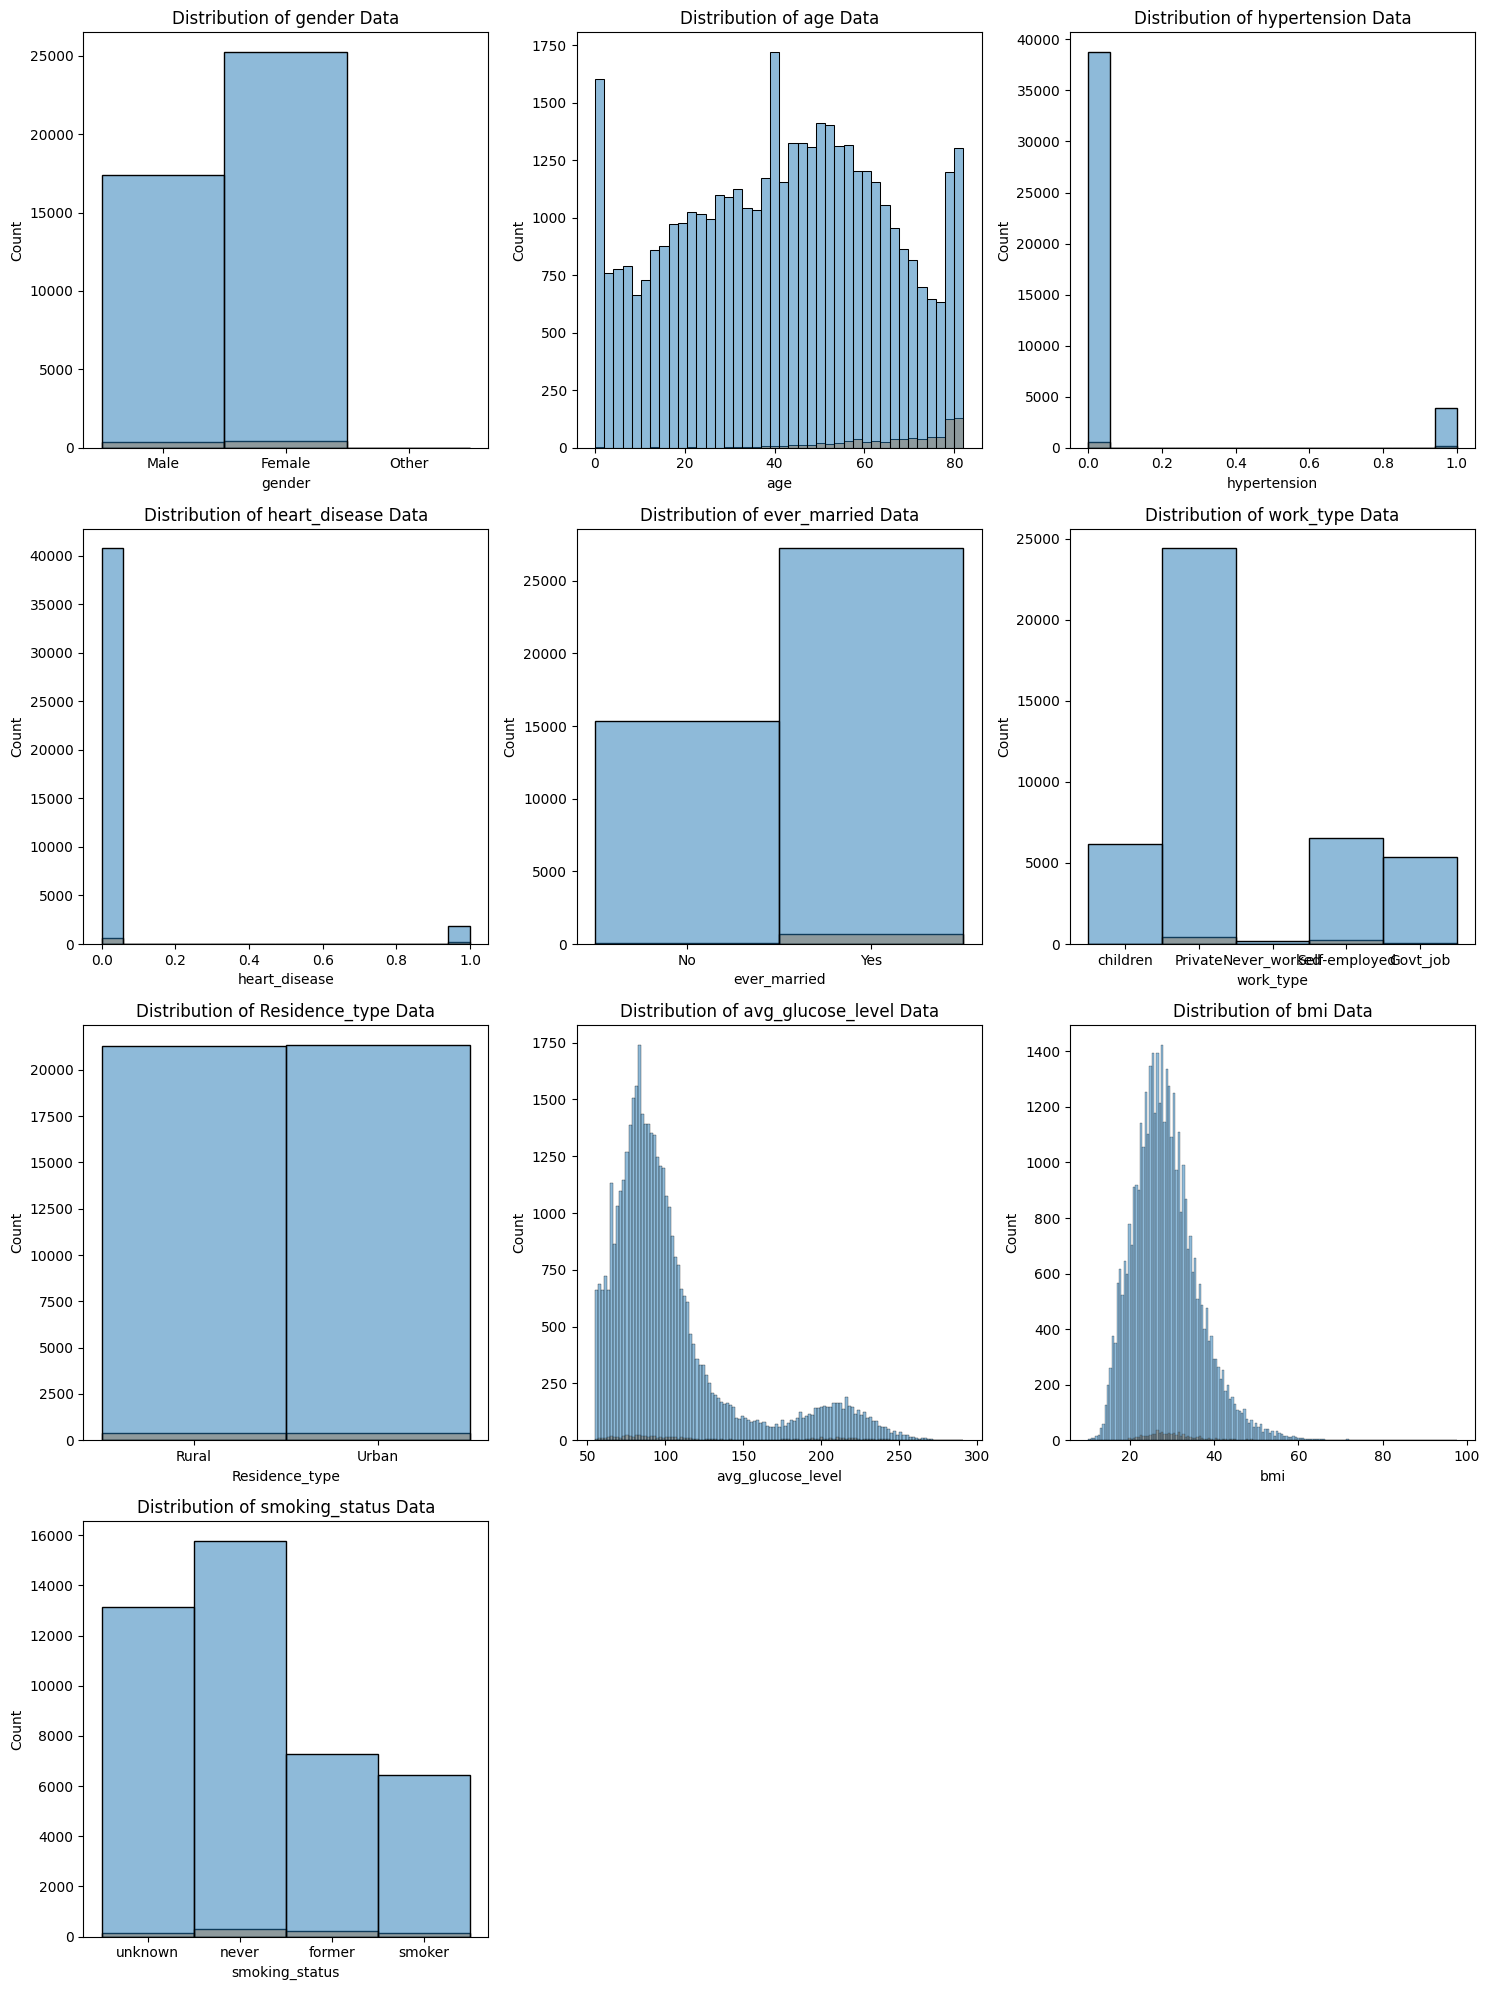

In [30]:
# Data histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(df.columns[:-1], 1):
  plt.subplot(4, 3, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=df, x=col, kde=False, hue='stroke', legend=False)
  plt.tight_layout()
  plt.plot()
plt.show()

##### Visualizing the Distribution if balanced

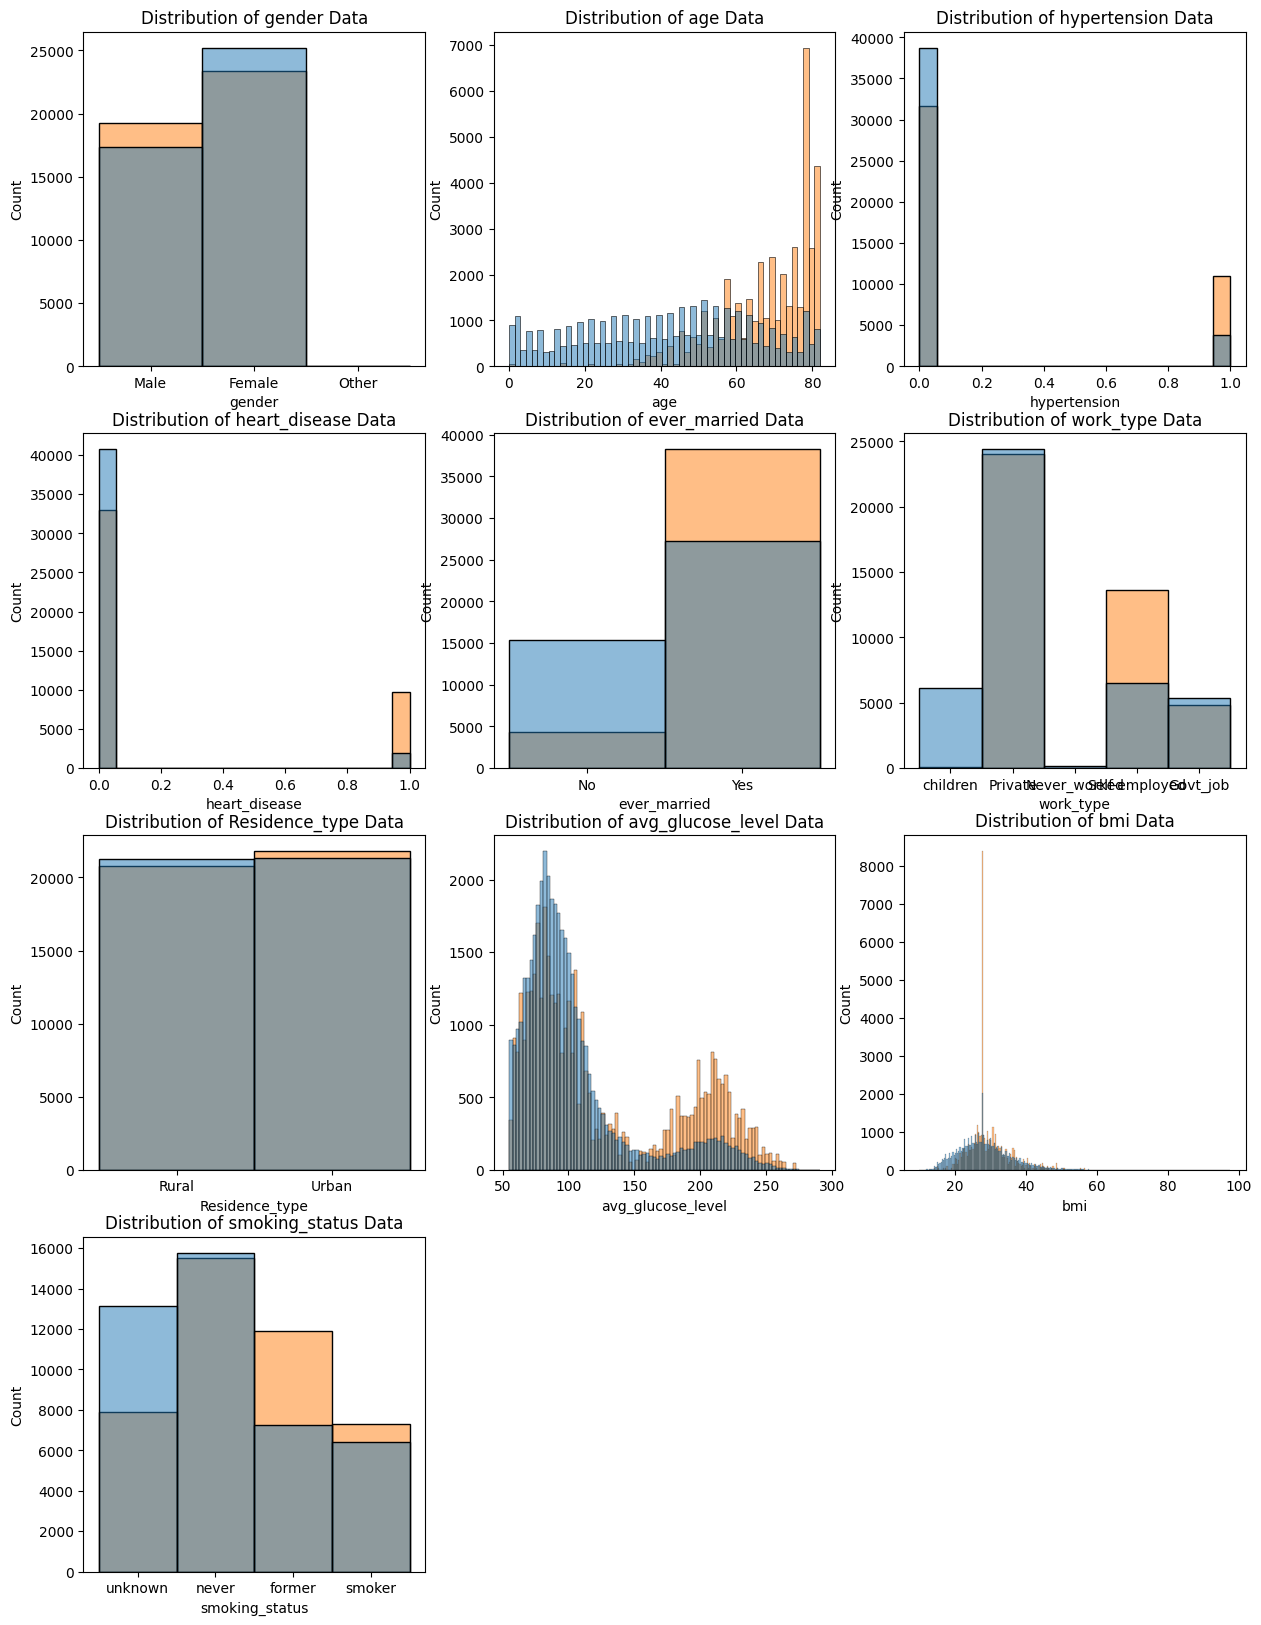

In [53]:
## BALANCE BASED ON TARGET (STROKE)
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
# fit and apply the transform
y = df.stroke
X, y = oversample.fit_resample(df, y)


# Look at histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(X.columns[:-1], 1):
  plt.subplot(4, 3, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=X, x=col, kde=False, hue='stroke', legend=False)
  plt.plot()
plt.show()

#### Impute Null values in `bmi` using median
Note: compared imputation with mean, median, and using logistic regression. All were relatively the same, but median generally performed best for most models (and is much simpler than regression).  
Note: while the right thing to do would be to impute using the median of the training data, there is very little difference overall when imputing with different values and median is unlikely to vary by much between overall and training datasets.

In [33]:
# impute missing 'bmi' values with median
df.bmi.fillna(df.bmi.median(), inplace=True)
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

#### Encoding Categorical Variables

None of the 'Other' gender had a stroke and it's only 0.03% of the dataset, so removing those 11 in the interest of simplifying and reducing overall complexity. Maybe this is an ethical concern to consider.

In [34]:
DF = df[df['gender'] != 'Other'].copy()

In [35]:
## ENCODE BINARY VALUES
# encode Yes/No to 1/0
DF.ever_married.replace(['Yes', 'No'], [1, 0], inplace=True)
# encode gender to 1/0
DF.gender.replace(['Male', 'Female'], [1, 0], inplace=True)
# encode Urban/Rural to 1/0
DF.Residence_type.replace(['Rural', 'Urban'], [1, 0], inplace=True)

In [36]:
## ONE HOT ENCODE CATEGORICAL VALUES
# one hot encode remaining categorical variables
transformer = make_column_transformer(
    (OneHotEncoder(), ['work_type', 'smoking_status']), 
    remainder='passthrough')
transformed = transformer.fit_transform(DF)
DF = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), 
                  index=DF.index) # fix index that was reset

# remove prefixes added by OneHotEncoder()
DF.columns = DF.columns.str.replace("onehotencoder__", "")
DF.columns = DF.columns.str.replace("remainder__", "")

### Train/Test Split

In [37]:
## SEPARATE DATA FROM TARGET
X, y = DF.iloc[:,:-1], DF.iloc[:,-1]

## SPLIT TRAINING AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42, 
  stratify=y) # stratify to maintain proportion of target variable

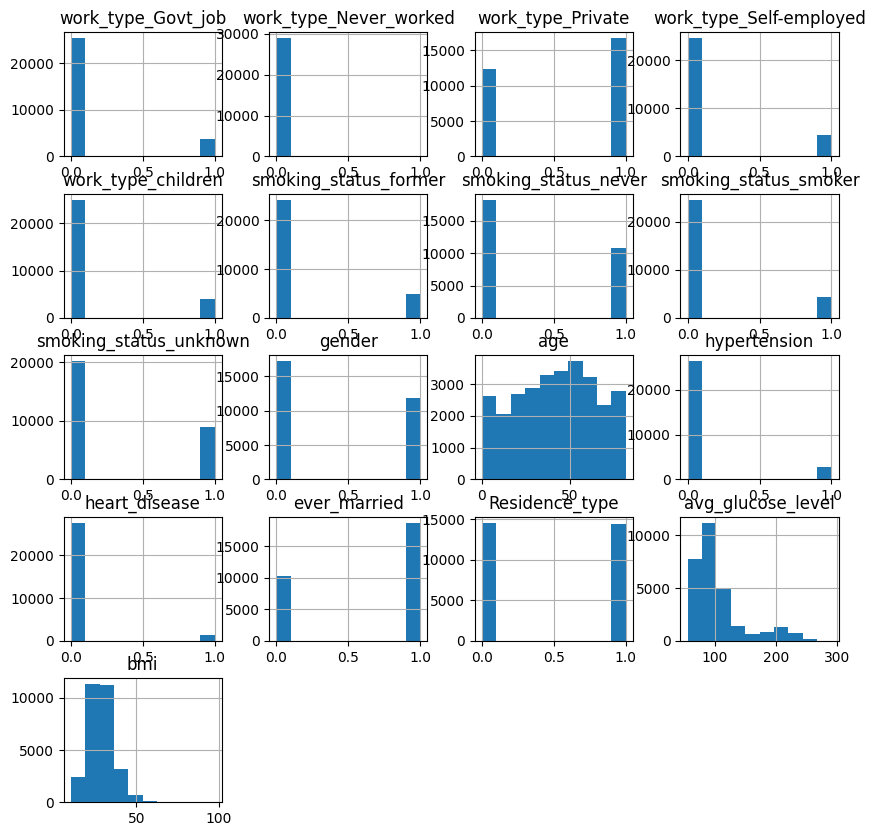

In [38]:
# Look at distributions pre-transformation
X_train.hist(figsize=(10,10))
plt.show()

In [39]:
## TRANSFORM FEATURES)
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('p', power)])

# specify columns to box-cox transform
cols_to_transform = ['age', 'avg_glucose_level', 'bmi']
# transform features and apply to both train and test sets
for i in cols_to_transform:
  X_train[i] = pipeline.fit_transform(X_train[i].values.reshape(-1,1))
  X_test[i] = pipeline.transform(X_test[i].values.reshape(-1,1))

# scale entire dataset to the same range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

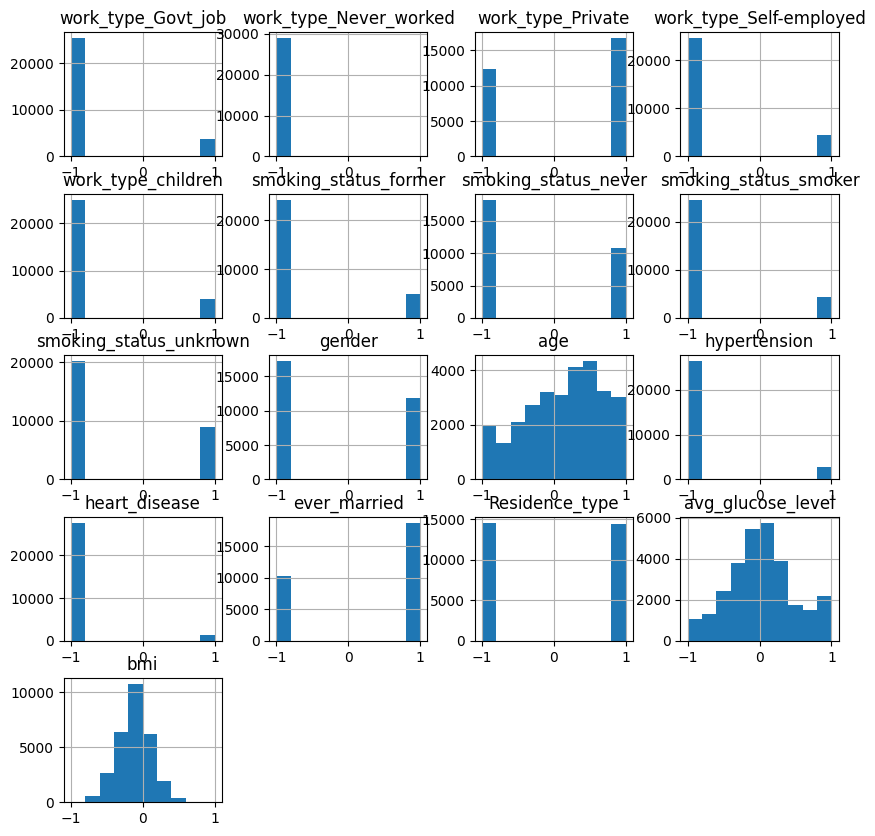

In [40]:
# Look at distributions post-transformation
dataset = pd.DataFrame(X_train, columns=DF.columns[:-1])
dataset.hist(figsize=(10,10))
plt.show()

#### Balancing Train Dataset

In [41]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', 
                              #  sampling_strategy=0.5, # sample to 50%
                                random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [42]:
# summarize target class distribution
counter = Counter(y_train)
print(counter)

Counter({0.0: 28545, 1.0: 525})


In [43]:
# Using SMOTE
oversample = SMOTE(sampling_strategy='minority',
                   random_state=42)
# fit and apply the transform
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

# summarize target class distribution
counter = Counter(y_smote)
print(counter)

Counter({0.0: 28545, 1.0: 28545})


In [44]:
# define oversampling strategy
over = SMOTE(sampling_strategy=0.1, # upsample to 10% of majority
             random_state=42)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5, # sample to 50% ratio
                           random_state=42)
# define pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# fit and apply the transform
X_ou_smote, y_ou_smote = pipeline.fit_resample(X_train, y_train)

### Classifiers Comparison

In [45]:
model_compare = pd.DataFrame()

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall', 'MCC', 'AUC'] 
  # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
  print(cm)
  disp.plot()
  plt.show()  
  
  # get accuracy, f1-score, precision, and recall
  # accuracy = round(model.score(X_test, y_test)*100, 2)
  cr = classification_report(y_test, predictions, output_dict=True)
  accuracy = round(cr['accuracy']*100, 2)
  print('Accuracy: ', accuracy)
  f1Score = round(cr['1.0']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  precision = round(cr['1.0']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['1.0']['recall'], 4)
  print('Recall:   ', recall)
  MCC = round(matthews_corrcoef(y_test, predictions), 4)
  print('MCC:      ', MCC)
  # weighted AUC
  AUC = round(roc_auc_score(y_test, predictions, average='weighted'), 4)
  print('AUC:      ', AUC)

  df = pd.DataFrame([[name, accuracy, f1Score, precision, recall, MCC, AUC]], 
                    columns=cols)
  return df

##### Random Forest

[[14056     5]
 [  258     0]]


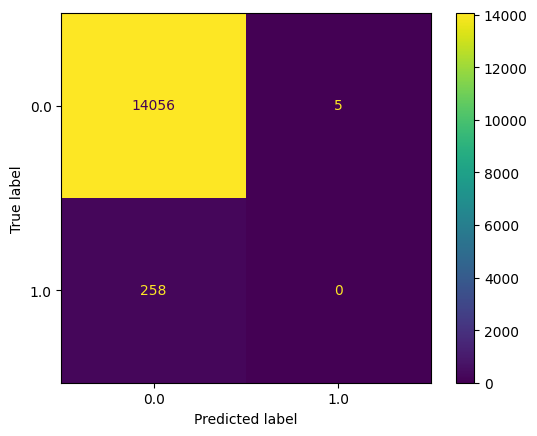

Accuracy:  98.16
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0025
AUC:       0.4998


In [47]:
rfClass = RandomForestClassifier(class_weight='balanced')
rfClass.fit(X_train, y_train)

# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### Decision Tree

[[13830   231]
 [  237    21]]


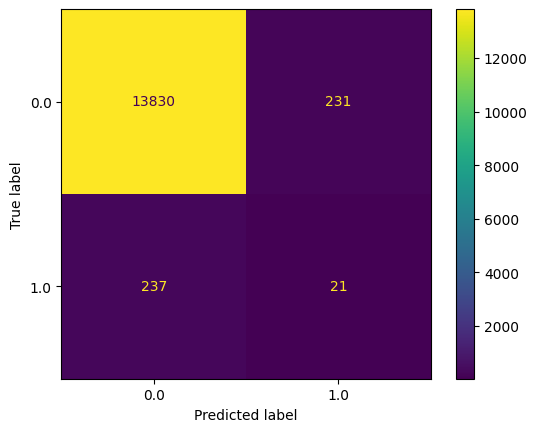

Accuracy:  96.73
F1-Score:  0.0824
Precision: 0.0833
Recall:    0.0814
MCC:       0.0657
AUC:       0.5325


In [48]:
decisiontree = DecisionTreeClassifier(class_weight='balanced')
decisiontree.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### Logistic Regression

[[10391  3670]
 [   48   210]]


F:\Anaconda_env\GNN4ID_2\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


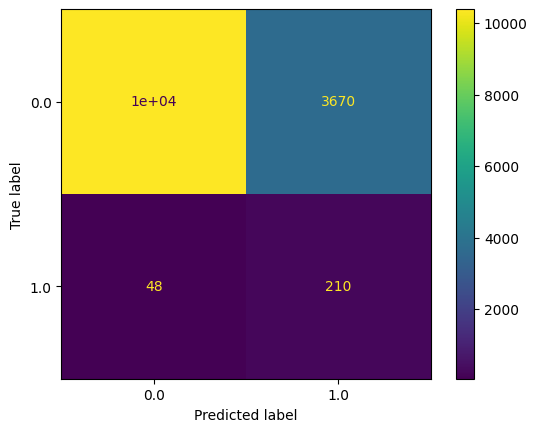

Accuracy:  74.03
F1-Score:  0.1015
Precision: 0.0541
Recall:    0.814
MCC:       0.1655
AUC:       0.7765


In [49]:
logit = LogisticRegression(class_weight='balanced')
logit.fit(X_train, y_train)
tempDF = get_model_metrics('LogReg_lbfgs', logit)
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[10391  3670]
 [   48   210]]


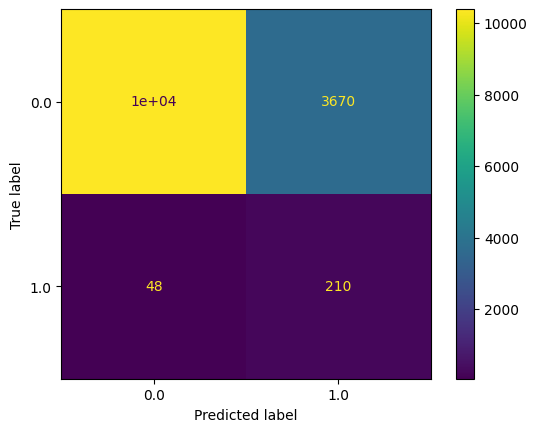

Accuracy:  74.03
F1-Score:  0.1015
Precision: 0.0541
Recall:    0.814
MCC:       0.1655
AUC:       0.7765


In [51]:
logit = LogisticRegression(class_weight='balanced',
                           solver='liblinear')
logit.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('LogReg_liblinear', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [52]:
import warnings
warnings.filterwarnings('ignore')

##### Guassian Naive Bayes Classifier

[[ 2966 11095]
 [    2   256]]


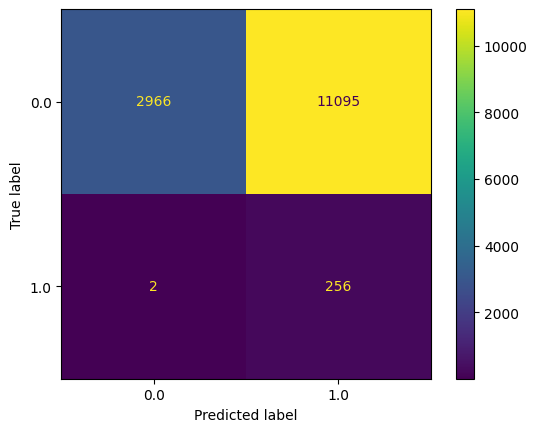

Accuracy:  22.5
F1-Score:  0.0441
Precision: 0.0226
Recall:    0.9922
MCC:       0.0667
AUC:       0.6016


In [54]:
# Create Gaussian naive Bayes object
nBayes = GaussianNB()
# Fit model
nBayes.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[13961   100]
 [  252     6]]


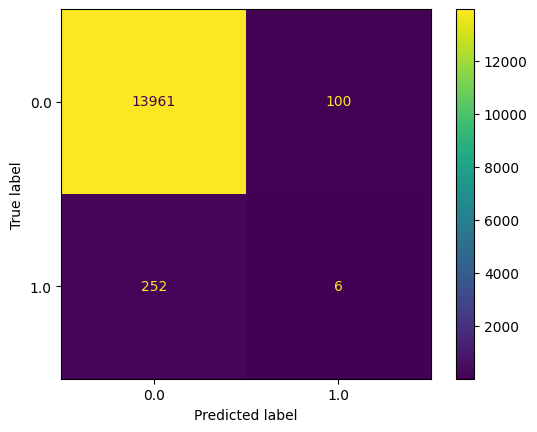

Accuracy:  97.54
F1-Score:  0.033
Precision: 0.0566
Recall:    0.0233
MCC:       0.0251
AUC:       0.5081


In [55]:
from sklearn.naive_bayes import BernoulliNB

# Create Gaussian naive Bayes object
nBayes = BernoulliNB()

# Fit model
nBayes.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('BernoulliNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### Support Vector Machine

[[10657  3404]
 [   68   190]]


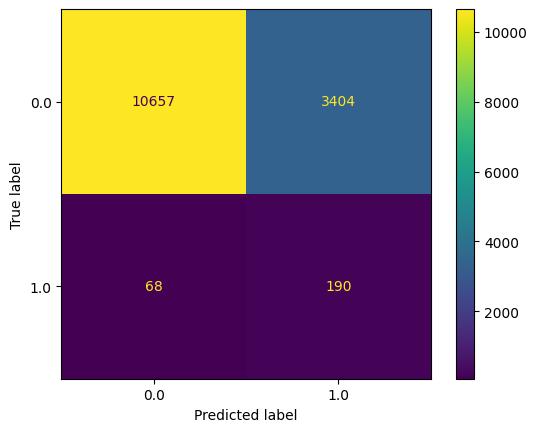

Accuracy:  75.75
F1-Score:  0.0987
Precision: 0.0529
Recall:    0.7364
MCC:       0.1517
AUC:       0.7472


In [57]:
# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

#### Linear SVC

[[10697  3364]
 [   58   200]]


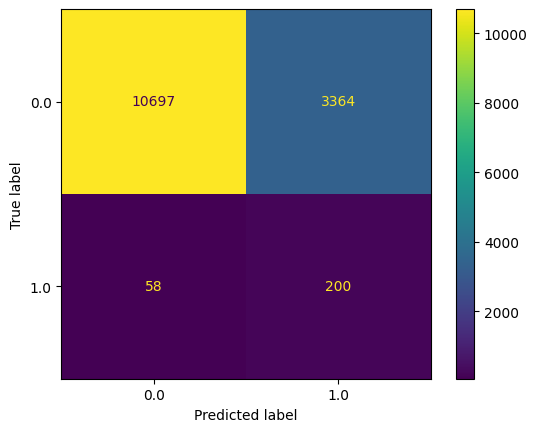

Accuracy:  76.1
F1-Score:  0.1047
Precision: 0.0561
Recall:    0.7752
MCC:       0.1649
AUC:       0.768


In [58]:
# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### AdaBoost Classifier

[[14060     1]
 [  258     0]]


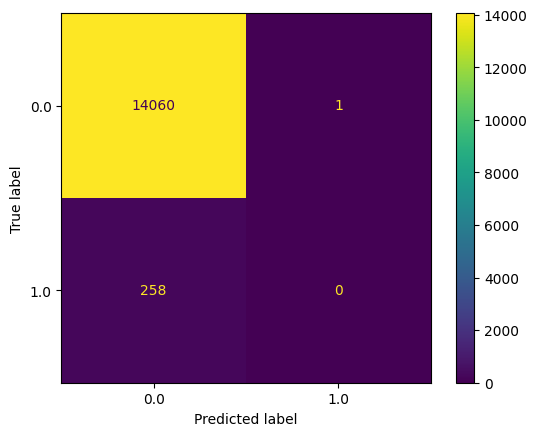

Accuracy:  98.19
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0011
AUC:       0.5


In [59]:
# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_train, y_train)
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### MLP Classifier

[[14061     0]
 [  258     0]]


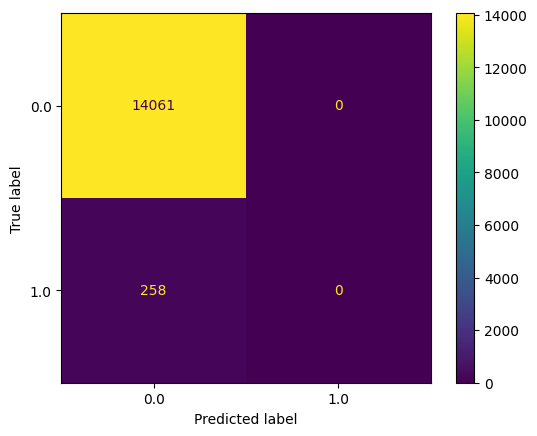

Accuracy:  98.2
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       0.0
AUC:       0.5


In [60]:
# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### Gradient Boosting Classifier

[[14053     8]
 [  258     0]]


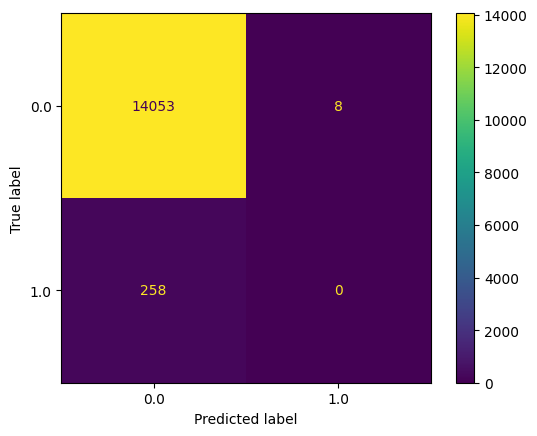

Accuracy:  98.14
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0032
AUC:       0.4997


In [61]:
# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### K-Nearest Neighbor

[[14046    15]
 [  257     1]]


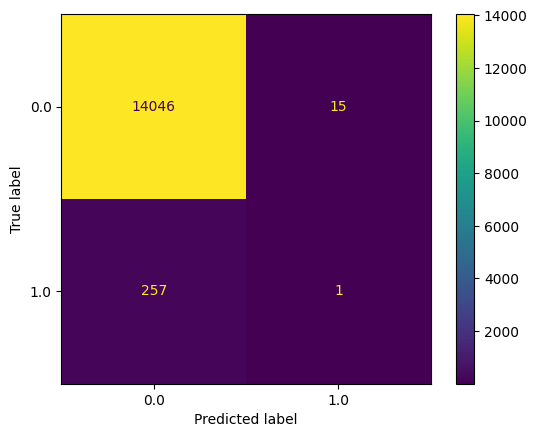

Accuracy:  98.1
F1-Score:  0.0073
Precision: 0.0625
Recall:    0.0039
MCC:       0.0112
AUC:       0.5014


In [62]:
# Create classification model
knn = KNeighborsClassifier(2)

# Fit model
knn.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('KNN', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### Stochastic Gradient Descent

[[11099  2962]
 [   73   185]]


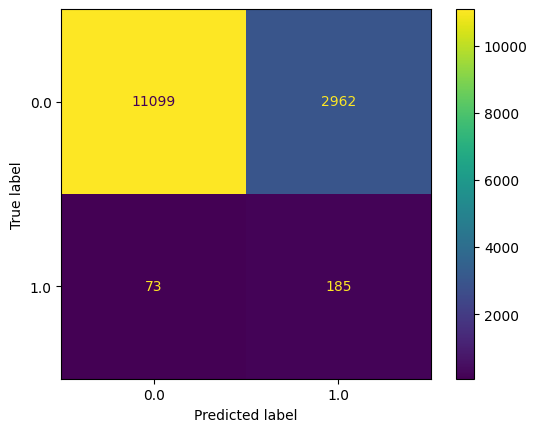

Accuracy:  78.8
F1-Score:  0.1087
Precision: 0.0588
Recall:    0.7171
MCC:       0.1627
AUC:       0.7532


In [63]:
# Create classification model
sgd = SGDClassifier(class_weight='balanced')

# Fit model
sgd.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('SGD', sgd)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### LGBM Classifier

[LightGBM] [Info] Number of positive: 525, number of negative: 28545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 29070, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[[12403  1658]
 [  132   126]]


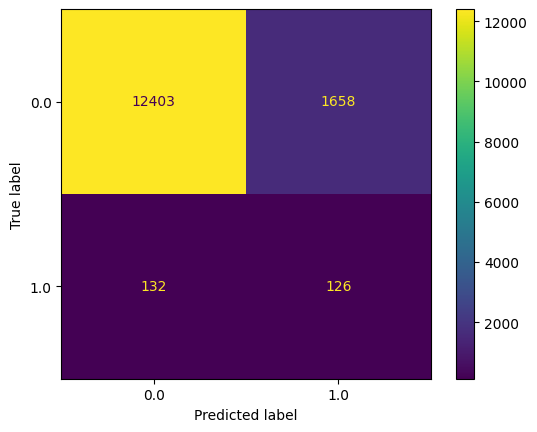

Accuracy:  87.5
F1-Score:  0.1234
Precision: 0.0706
Recall:    0.4884
MCC:       0.1492
AUC:       0.6852


In [64]:
# Create classification model
lgbm = LGBMClassifier(class_weight='balanced')

# Fit model
lgbm.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('LGBM', lgbm)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### XGBoost Classfiier

[[14046    15]
 [  256     2]]


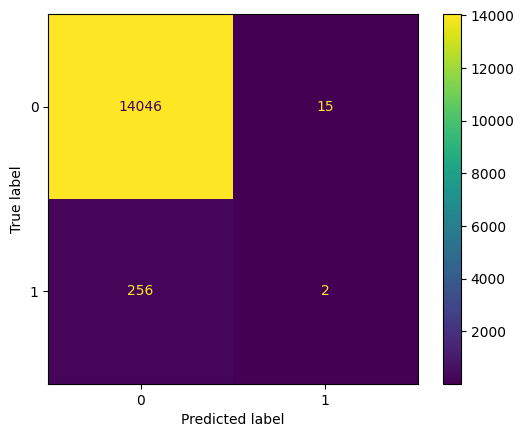

Accuracy:  98.11
F1-Score:  0.0145
Precision: 0.1176
Recall:    0.0078
MCC:       0.0258
AUC:       0.5033


In [65]:
# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

##### Linear Discriminant Analysis

[[13895   166]
 [  236    22]]


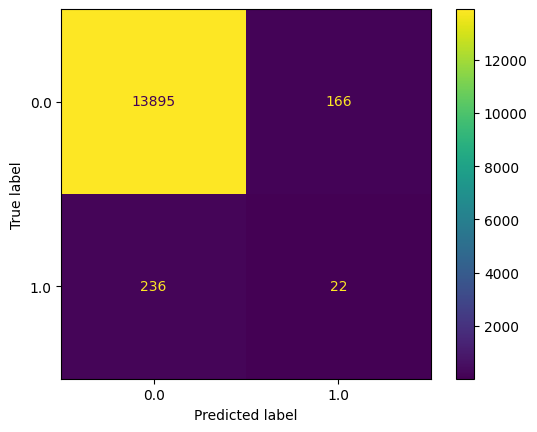

Accuracy:  97.19
F1-Score:  0.0987
Precision: 0.117
Recall:    0.0853
MCC:       0.0858
AUC:       0.5367


In [67]:
# Create classification model
lda = LinearDiscriminantAnalysis()
# Fit model
lda.fit(X_train, y_train)
# Evaluate model
tempDF = get_model_metrics('LDA', lda)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

### Model Performances

In [69]:
model_compare.sort_values('MCC', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg_lbfgs,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
1,LogReg_liblinear,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
2,LinearSVC,76.10,0.1047,0.0561,0.7752,0.1649,0.7680
3,SGD,78.80,0.1087,0.0588,0.7171,0.1627,0.7532
4,SVC,75.75,0.0987,0.0529,0.7364,0.1517,0.7472
5,LGBM,87.50,0.1234,0.0706,0.4884,0.1492,0.6852
6,LDA,97.19,0.0987,0.1170,0.0853,0.0858,0.5367
7,GaussianNB,22.50,0.0441,0.0226,0.9922,0.0667,0.6016
8,DecisionTree,96.73,0.0824,0.0833,0.0814,0.0657,0.5325
9,XGBC,98.11,0.0145,0.1176,0.0078,0.0258,0.5033


#### Hyper-Parameter Tuning

In [70]:
mcc = make_scorer(matthews_corrcoef)

In [71]:
# Logistic Regression
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],# 'none', 'elasticnet'],
    'tol': [1e-7, 1e-5], #, 1e-3
    'C': [0.1, 1], #, 10
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']#,'newton-cg']
}

# Set up grid search
grid = GridSearchCV(logit, parameter_space, scoring=mcc, cv=5)
# Fit models
grid_result = grid.fit(X_train, y_train)
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		16.54


[[10387  3674]
 [   48   210]]


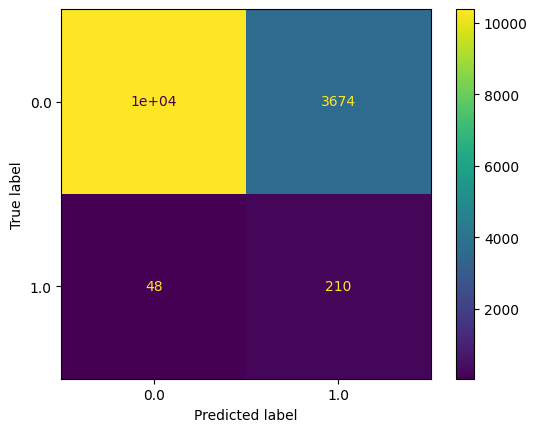

Accuracy:  74.01
F1-Score:  0.1014
Precision: 0.0541
Recall:    0.814
MCC:       0.1653
AUC:       0.7763


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg,74.01,0.1014,0.0541,0.814,0.1653,0.7763


In [72]:
logit = LogisticRegression(class_weight='balanced',
                           C=0.1, penalty='l2', solver='liblinear', tol=1e-7,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LogReg', logit)

##### Linear SVC

In [73]:
# Create classifier
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2000,
                   random_state=42)

# Get a baseline model
baseline = linSVC.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],
    'loss': ['squared_hinge'], #'hinge', 
    'dual': [True, False],
    'tol': [1e-8, 1e-6, 1e-4],
    'C': [1, 10, 100] # 0.1, 
}
# Set up grid search
grid = GridSearchCV(linSVC, parameter_space, scoring=mcc, cv=5)
grid_result = grid.fit(X_train, y_train)

# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 1e-08} 

Baseline Accuracy:	73.55
Tuned Accuracy:		16.36


[[10269  3792]
 [   46   212]]


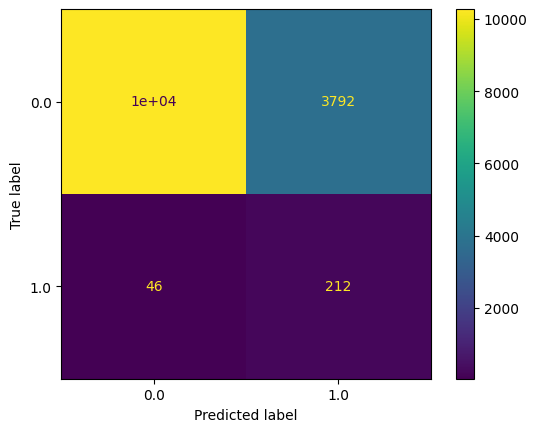

Accuracy:  73.2
F1-Score:  0.0995
Precision: 0.0529
Recall:    0.8217
MCC:       0.1636
AUC:       0.776


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LinSVC,73.2,0.0995,0.0529,0.8217,0.1636,0.776


In [76]:
# Create classification model
linSVC = LinearSVC(class_weight='balanced',
                   C=10, dual=False, loss='squared_hinge', 
                   penalty='l2', tol=1e-8)

# Fit model
linSVC.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LinSVC', linSVC)

#### Hyperparameter Tuning using multiple metrics

In [77]:
# Set up metrics to use for scoring
mcc = make_scorer(matthews_corrcoef)
scoring = {'MCC': mcc, 'Recall': 'recall', 'AUC': 'roc_auc'}

In [78]:
# Create classifier
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'], #'none', 
    'tol': [1e-7, 1e-5], #, 1e-3
    'C': [0.1, 1], #, 10
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}
# Set up grid search
grid = GridSearchCV(logit, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

# Fit models
grid_result = grid.fit(X_train, y_train)

print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		16.54


[[10387  3674]
 [   48   210]]


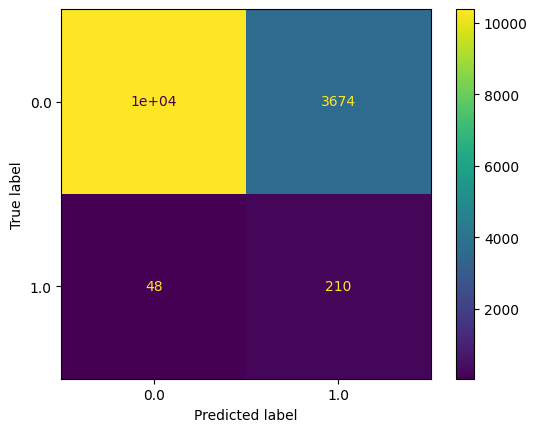

Accuracy:  74.01
F1-Score:  0.1014
Precision: 0.0541
Recall:    0.814
MCC:       0.1653
AUC:       0.7763


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg,74.01,0.1014,0.0541,0.814,0.1653,0.7763


In [79]:
# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           penalty='l2', solver='liblinear', 
                           tol=1e-7, C=0.1,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LogReg', logit)

##### Linear SVC

In [80]:
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2000,
                   random_state=42)

# Get a baseline model
baseline = linSVC.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],
    'loss': ['squared_hinge'], #'hinge', 
    'dual': [True, False],
    'tol': [1e-8, 1e-6, 1e-4],
    'C': [1, 10, 100]
}
# Evaluate tuned parameters
grid = GridSearchCV(linSVC, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)
# Fit models
grid_result = grid.fit(X_train, y_train)

print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 1e-08} 

Baseline Accuracy:	73.55
Tuned Accuracy:		16.36


[[10269  3792]
 [   46   212]]


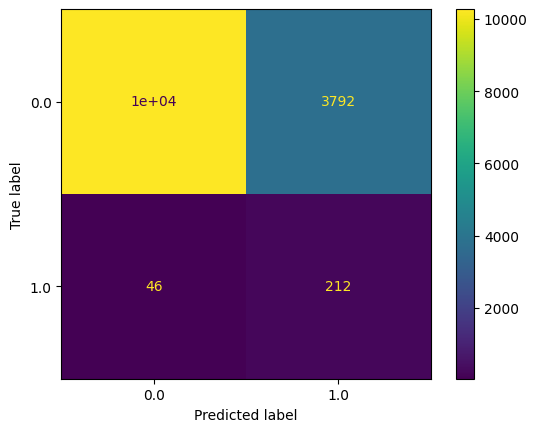

Accuracy:  73.2
F1-Score:  0.0995
Precision: 0.0529
Recall:    0.8217
MCC:       0.1636
AUC:       0.776


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LinSVC,73.2,0.0995,0.0529,0.8217,0.1636,0.776


In [81]:
# Create classification model
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2500, random_state=42,
                   C=10, dual=False, loss='squared_hinge', 
                   penalty='l2', tol=1e-7)

# Fit model
linSVC.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LinSVC', linSVC)

##### Support Vector Classifier

In [82]:
svc = SVC(class_weight='balanced',
          random_state=42)

# Get a baseline model
baseline = svc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'kernel': ['linear'],# 'poly', 'rbf', 'sigmoid'] # follow up w/other params
    'C': [10, 100], #0.1, 1, 1000
    # 'gamma': ['scale', 'auto'],
    # 'shrinking': [True, False],
    # 'probability': [True, False],
    'tol': [1e-3, 1e-2]#, 1e-4, 0.1]
}
# Set up grid search
grid = GridSearchCV(svc, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)
# grid = RandomizedSearchCV(svc, parameter_space, scoring=scoring, cv=5, 
#                           refit='MCC', return_train_score=True,
#                           n_iter=30, random_state=42)
# Fit models
grid_result = grid.fit(X_train, y_train)

print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 100, 'kernel': 'linear', 'tol': 0.01} 

Baseline Accuracy:	75.75
Tuned Accuracy:		16.29


[[10214  3847]
 [   45   213]]


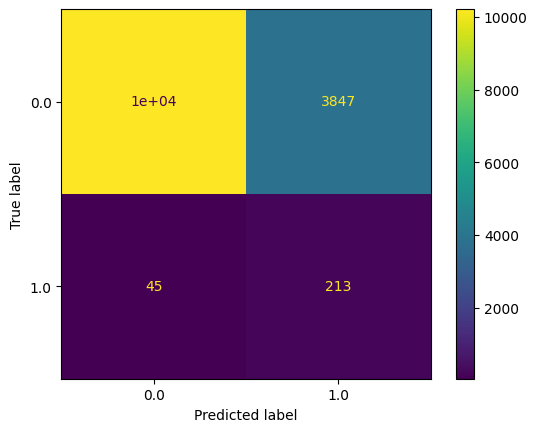

Accuracy:  72.82
F1-Score:  0.0987
Precision: 0.0525
Recall:    0.8256
MCC:       0.1629
AUC:       0.776


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,SVC,72.82,0.0987,0.0525,0.8256,0.1629,0.776


In [83]:
# Create classification model
svc = SVC(class_weight='balanced',
          kernel='linear', C=100, tol=0.01,
          random_state=42)

# Fit model
svc.fit(X_train, y_train)

# Evaluate model
get_model_metrics('SVC', svc)

##### Stochastic Gradient Descent

In [84]:
# Create classifier
sgd = SGDClassifier(class_weight='balanced',
                    max_iter=5000,
                    early_stopping=True,
                    random_state=42)

# Get a baseline model
baseline = sgd.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge',
             'perceptron', 'squared_error', 'huber', 'epsilon_insensitive',
             'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'tol': [1e-7, 1e-5, 1e-3],
    'epsilon': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}
# grid = GridSearchCV(sgd, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)
grid = GridSearchCV(sgd, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

# Fit models
grid_result = grid.fit(X_train, y_train)

print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'alpha': 0.001, 'epsilon': 0.1, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2', 'tol': 0.001} 

Baseline Accuracy:	80.45
Tuned Accuracy:		15.07


[[10052  4009]
 [   45   213]]


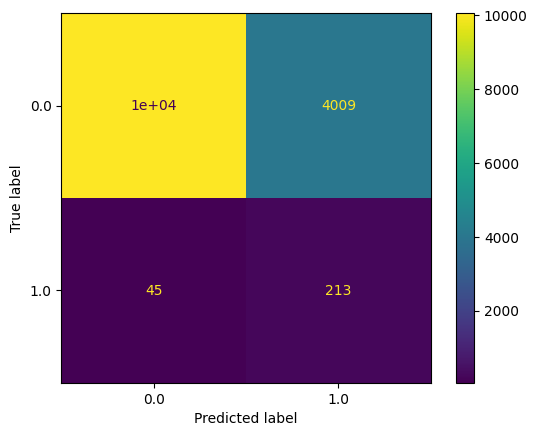

Accuracy:  71.69
F1-Score:  0.0951
Precision: 0.0505
Recall:    0.8256
MCC:       0.1577
AUC:       0.7702


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,SGD,71.69,0.0951,0.0505,0.8256,0.1577,0.7702


In [85]:
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced',
                    alpha=0.0001, epsilon=0.01, learning_rate='optimal',
                    loss='huber', penalty='l2', tol=1e-7,
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Fit model
sgd.fit(X_train, y_train)

# Evaluate model
get_model_metrics('SGD', sgd)

### Ensembles 

In [86]:
from sklearn.ensemble import VotingClassifier
# split the full train set into train and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, 
                                                          test_size=0.33, 
                                                          random_state=42)

In [87]:
# set up a collection of base models to include
def get_models():
	models = list()
	models.append(('LogReg', logit))
	models.append(('LinSVC', linSVC))
	models.append(('SVC', svc))
	models.append(('SGD', sgd)) 
	# models.append(('LGBM', lgbm)) 
	# models.append(('LDA', lda)) 
	# models.append(('GNB', nBayes)) 
	# models.append(('DT', decisiontree)) 
	# models.append(('KNN', knn)) 
	# models.append(('MLP', mlp)) 
	# models.append(('XGBC', xgbc)) 
	# models.append(('AdaB', adaboost)) 
	# models.append(('RF', rfClass)) 
	# models.append(('GBC', gbc)) 
 
	return models

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		auc = roc_auc_score(y_val, yhat, average='weighted')
		# store the performance
		scores.append(auc)
		# report model performance
	return scores

In [88]:
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = roc_auc_score(y_test, yhat, average='weighted')
print('Weighted AUC: %.3f' % (score*100))

[0.7770317259780631, 0.7819073560682706, 0.7900388814308454, 0.75906653385101]
Weighted AUC: 77.658


[[10285  3776]
 [   46   212]]


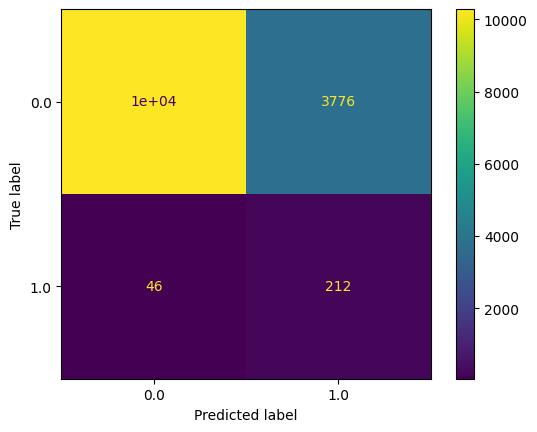

Accuracy:  73.31
F1-Score:  0.0999
Precision: 0.0532
Recall:    0.8217
MCC:       0.1641
AUC:       0.7766


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_AUC,73.31,0.0999,0.0532,0.8217,0.1641,0.7766


In [89]:
# Evaluate model
get_model_metrics('Ensemble_AUC', ensemble)

In [90]:
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		rec = recall_score(y_val, yhat)
		# store the performance
		scores.append(rec)
		# report model performance
	return scores

[0.837696335078534, 0.8534031413612565, 0.8743455497382199, 0.9319371727748691]
Weighted Recall: 82.171
[[10262  3799]
 [   46   212]]


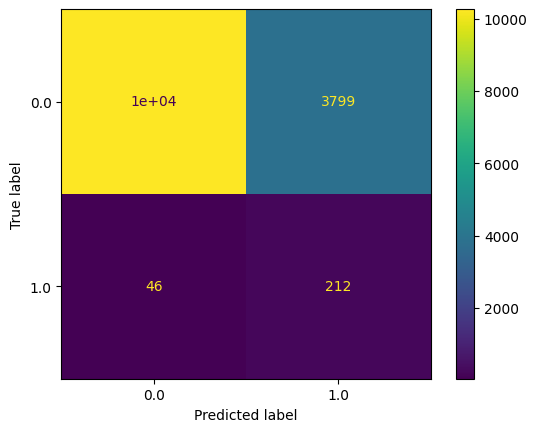

Accuracy:  73.15
F1-Score:  0.0993
Precision: 0.0529
Recall:    0.8217
MCC:       0.1634
AUC:       0.7758


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_Recall,73.15,0.0993,0.0529,0.8217,0.1634,0.7758


In [91]:
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = recall_score(y_test, yhat)
print('Weighted Recall: %.3f' % (score*100))

# Evaluate model
get_model_metrics('Ensemble_Recall', ensemble)

##### Voting Using Matthews Correlation Coefficient Metric

In [92]:
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		mcc = matthews_corrcoef(y_val, yhat)
		# store the performance
		scores.append(mcc)
		# report model performance
	return scores

In [93]:
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = matthews_corrcoef(y_test, yhat)
print('Weighted MCC: %.3f' % (score*100))

[0.16976509962266212, 0.17172819907162, 0.17586076157131855, 0.1464472516600709]
Weighted MCC: 16.414


[[10285  3776]
 [   46   212]]


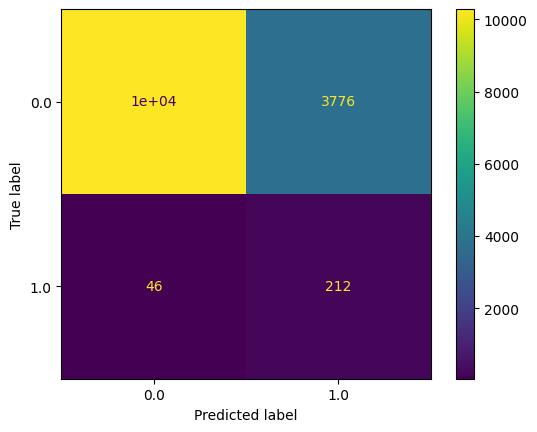

Accuracy:  73.31
F1-Score:  0.0999
Precision: 0.0532
Recall:    0.8217
MCC:       0.1641
AUC:       0.7766


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_MCC,73.31,0.0999,0.0532,0.8217,0.1641,0.7766


In [94]:
# Evaluate model
get_model_metrics('Ensemble_MCC', ensemble)

#### Stacking Classifier

[[10331  3730]
 [   48   210]]


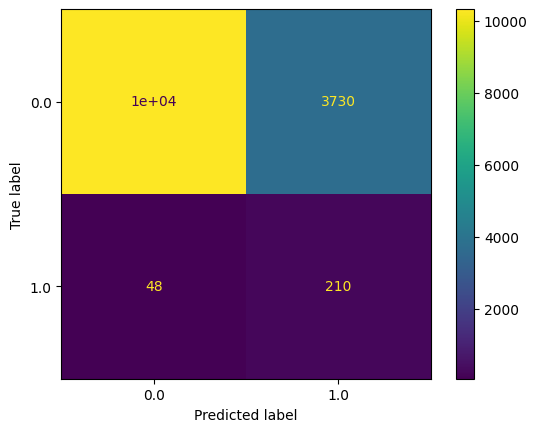

Accuracy:  73.62
F1-Score:  0.1
Precision: 0.0533
Recall:    0.814
MCC:       0.1634
AUC:       0.7743


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Stacking,73.62,0.1,0.0533,0.814,0.1634,0.7743


In [95]:
# set up estimmator for classifier
final_estimator = LogisticRegression(class_weight='balanced')
# create the ensemble
stk = StackingClassifier(
    estimators=models,
    final_estimator=final_estimator
)
# fit the model
stk.fit(X_train, y_train)

# evaluate model
get_model_metrics('Stacking', stk)

#### Bagging Classifier 

[[10399  3662]
 [   48   210]]


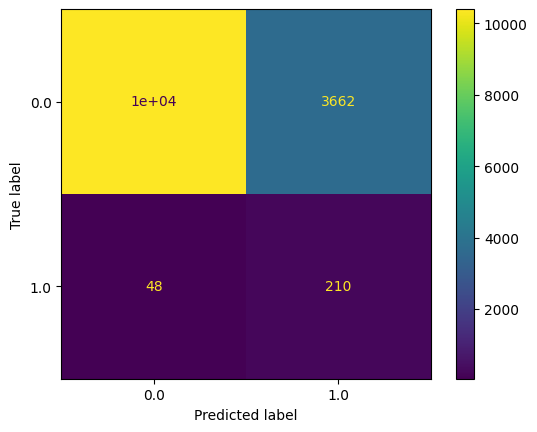

Accuracy:  74.09
F1-Score:  0.1017
Precision: 0.0542
Recall:    0.814
MCC:       0.1658
AUC:       0.7768


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_bag,74.09,0.1017,0.0542,0.814,0.1658,0.7768


In [96]:
# create the ensemble and fit model
clf = BaggingClassifier(base_estimator=logit, n_estimators=10,
                        random_state=42).fit(X_train, y_train)
# evaluate model
get_model_metrics('Ensemble_bag', clf)  